# Unsupervised Learning - Clustering

### Import The nessasary libraries


In [2]:
# Import Wikipedia API for fetching articles
import wikipediaapi
# Natural Language Toolkit for text processing
import nltk
# SSL and Re (Regex) for network/text handling
import ssl
import re
# NumPy for numerical operations
import numpy as np
# NLTK modules: Stopwords (common words) and Lemmatizer (root form)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Scikit-Learn: TfidfVectorizer (Text -> Numbers) and KMeans (Clustering)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# SSL Context fix for Mac/Windows certification errors
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download necessary NLTK datasets
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

print("Wikipedia API loaded successfully.")
print("NLTK resources downloaded successfully.")


Wikipedia API loaded successfully.
NLTK resources downloaded successfully.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chamm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chamm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\chamm\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Test Wikipedia API

Before fetching all data, we test the API by retrieving a single page (Sigiriya) to ensure everything is working.


In [3]:
# Initialize the Wikipedia API with a user agent
wiki_api = wikipediaapi.Wikipedia('Sigiriya','en')

# Fetch a test page
page = wiki_api.page('Sigiriya')

# Print the content of the page
print(page.text)


Sigiriya or Sinhagiri (Lion  Rock Sinhala: සීගිරිය, Tamil: சிகிரியா/சிங்ககிரி, pronounced SEE-gi-ri-yə) is an ancient rock fortress located in the northern Matale District near the town of Dambulla in the Central Province, Sri Lanka. It is a site of historical and archaeological significance that is dominated by a massive column of granite approximately 180 m (590 ft) high.
According to the ancient Sri Lankan chronicle the Cūḷavaṃsa, this area was a large forest, then after storms and landslides it became a hill and was selected by King Kashyapa (CE 477–495) for his new capital. He built his palace on top of this rock and decorated its sides with colourful frescoes. On a small plateau about halfway up the side of this rock he built a gateway in the form of an enormous lion. The name of this place is derived from this structure; Sinhagiri, the Lion Rock.
The capital and the royal palace were abandoned after the king's death. It was used as a Buddhist monastery until the 14th century. Si

In [4]:
# Define the list of articles to cluster.
# We chose topics related to 3 main categories: Astrophysics, Biology, and Computer Science.
article_titles = [
    "Galaxy", "Black Hole", "Supernova",               # Astrophysics
    "DNA", "Photosynthesis", "Evolution",            # Biology
    "Artificial Intelligence", "Machine Learning", "Computer Programming" # Computer Science
]

# Initialize the Wikipedia API
# It is good practice to provide a specific User-Agent
wiki = wikipediaapi.Wikipedia(
    user_agent='MyClusteringProject/1.0 (contact@example.com)',
    language='en'
)

# Fetch the articles and store their text content
documents = []
for title in article_titles:
    page = wiki.page(title)
    if page.exists():
        documents.append(page.text)
        print(f"Page '{title}' fetched successfully.")
    else:
        print(f"Page '{title}' not found.")


Page 'Galaxy' fetched successfully.
Page 'Black Hole' fetched successfully.
Page 'Supernova' fetched successfully.
Page 'DNA' fetched successfully.
Page 'Photosynthesis' fetched successfully.
Page 'Evolution' fetched successfully.
Page 'Artificial Intelligence' fetched successfully.
Page 'Machine Learning' fetched successfully.
Page 'Computer Programming' fetched successfully.


### Data Preprocessing

In this step, we clean and prepare the text data for analysis.

- **Normalization**: We convert all text to lowercase and remove special characters to ensure uniformity.
- **Tokenization**: We split the text into individual words (tokens).
- **Stop Word Removal**: We remove common words (e.g., "the", "is") that add little meaning.
- **Lemmatization**: We reduce words to their base form (e.g., "running" -> "run") using WordNet Lemmatizer.


In [5]:
# Initialize Lemmatizer and Stop Words
lemanizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove special characters and numbers, keep only letters, and lowercasing
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())

    # Tokenize: Split string into list of words
    tokens = text.split()

    # Remove stopwords and Lemmatize (reduce to base form, e.g., 'running' -> 'run')
    process_words = [
        lemanizer.lemmatize(word, pos='v')
        for word in tokens if word not in stop_words
    ]

    # Join tokens back into a single string
    return ' '.join(process_words)

# Apply preprocessing to all downloaded documents
process_documents = [preprocess_text(doc) for doc in documents]

print("Documents processed successfully.")


Documents processed successfully.


### Feature Extraction (TF-IDF)

We convert text to numerical vectors using **TF-IDF**.

- **TF (Term Frequency)**: How often a word appears in a document.
- **IDF (Inverse Document Frequency)**: Reduces the weight of common words.
- We use `max_features=1000` to focus on the top 1000 most important words.


In [6]:
# Convert text data to numerical matrix
vectorizer = TfidfVectorizer(max_features=1000) # Keep top 1000 most frequent words

# Fit and Transform: Learn vocabulary and convert documents to vectors
tfid_matrix = vectorizer.fit_transform(process_documents)

print("Shape of Matrix:", tfid_matrix.shape) # (n_documents, n_features)
print("Feature Name Samples:", vectorizer.get_feature_names_out()[:10])


Shape of Matrix: (9, 1000)
Feature Name Samples: ['ability' 'able' 'absorb' 'absorption' 'academic' 'accelerate' 'accord'
 'accrete' 'accretion' 'accuracy']


### Clustering (K-Means)

We use **K-Means** to group the articles.

- **n_clusters=3**: We expect 3 groups (Astrophysics, Biology, CS).
- **n_init=20**: Runs the algorithm 20 times to find the best separation.


In [7]:
# Set number of clusters (k=3 for Astro, Bio, CS)
k = 3

# Initialize KMeans model
# n_init=20: Run algorithm 20 times with different seeds for better stability
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)

# Train the model on the TF-IDF matrix
kmeans.fit(tfid_matrix)

# Get cluster labels (0, 1, 2) for each document
cluster_labels = kmeans.labels_
print("Cluster labels assigned:", cluster_labels)


Cluster labels assigned: [2 2 2 0 0 0 1 1 1]


### Evaluation

We evaluate the model using:

- **WCSS (Inertia)**: Measures cluster compactness (lower is better).
- **Silhouette Score**: Measures separation (closer to 1 is better).


In [8]:
# Calculate Within-Cluster Sum of Squares (WCSS) / Inertia
# A lower WCSS indicates that data points are closer to their cluster centroid
wcss = kmeans.inertia_

# Calculate Silhouette Score
# Range: -1 to 1. Closer to 1 means well-separated clusters.
sil_score = silhouette_score(tfid_matrix, cluster_labels)

print("Model Training Completed")
print(f"WCSS (Inertia): {wcss:.2f}")
print(f"Silhouette Score: {sil_score:.4f}")


Model Training Completed
WCSS (Inertia): 4.48
Silhouette Score: 0.1053


### Prediction on New Data

We can now use our trained model to classify new, unseen sentences into one of the 3 clusters.


In [9]:
# Test the model on new, unseen data
new_sentences = [
    "The Hubble Space Telescope captured a new image of a distant galaxy.",
    "DNA replication is a fundamental process in all living organisms.",
    "Python is a popular programming language for data science."
]

# Transform the new data using the ALREADY FITTED vectorizer
# Note: We use .transform(), NOT .fit_transform(), to keep the same vocabulary
new_sentences_vectorized = vectorizer.transform(new_sentences)

# Predict the clusters using the trained KMeans model
predictions = kmeans.predict(new_sentences_vectorized)

# Print results
for sentence, cluster in zip(new_sentences, predictions):
    print(f"Sentence: '{sentence}' -> Cluster: {cluster}")

Sentence: 'The Hubble Space Telescope captured a new image of a distant galaxy.' -> Cluster: 2
Sentence: 'DNA replication is a fundamental process in all living organisms.' -> Cluster: 0
Sentence: 'Python is a popular programming language for data science.' -> Cluster: 1


### Cluster Visualization

We can visualize the clusters by reducing the high-dimensional TF-IDF vectors (1000 dimensions) to 2 dimensions using **PCA (Principal Component Analysis)**. This allows us to plot the articles on a 2D plane.


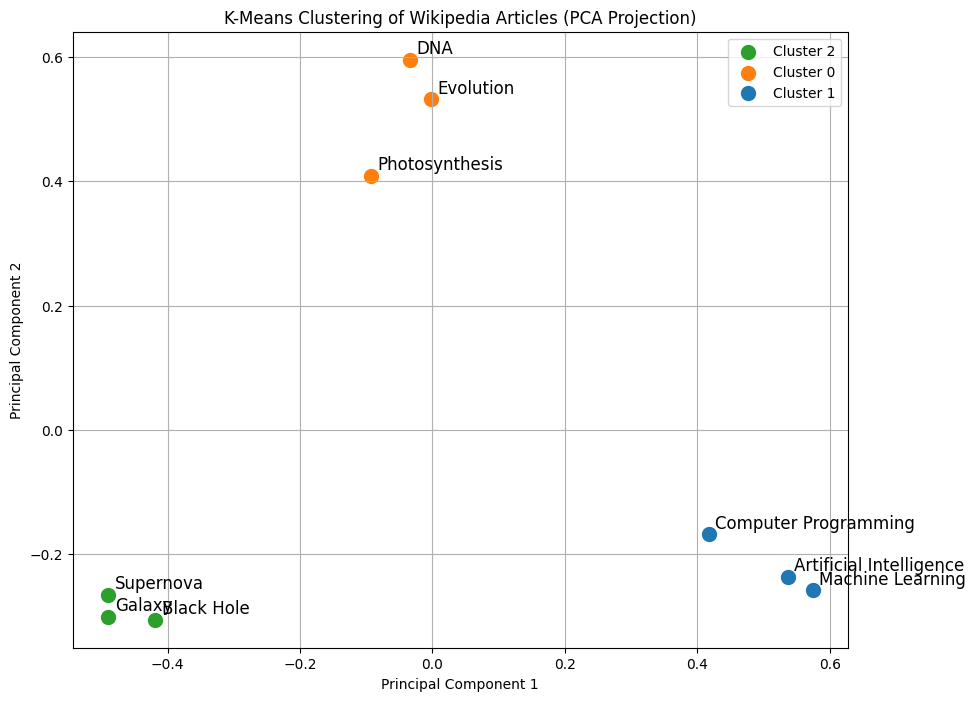

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Initialize PCA to reduce to 2 components
pca = PCA(n_components=2)

# Fit and transform the dense TF-IDF matrix
# Note: We verify if it is sparse and convert to array if needed
data_2d = pca.fit_transform(tfid_matrix.toarray())

# Plotting
plt.figure(figsize=(10, 8))

# Define colors for clusters (assuming k=3)
colors = ['#ff7f0e', '#1f77b4', '#2ca02c'] # Orange, Blue, Green

for i in range(len(data_2d)):
    x = data_2d[i, 0]
    y = data_2d[i, 1]
    label = cluster_labels[i]
    title = article_titles[i]

    plt.scatter(x, y, c=colors[label], s=100, label=f'Cluster {label}')
    plt.text(x + 0.01, y + 0.01, title, fontsize=12)

# Handle legend (remove duplicates)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('K-Means Clustering of Wikipedia Articles (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()